# Prevendo a próxima hora

Nesse projeto eu implementei um modelo para prever o número de corridas para a empresa *fictícia* Sweet Lift Taxi. O objetivo era prever o número de corridas na próxima hora para que os motoristas pudessem se antecipar ao horário de pico. Para isso, eu utilizei os dados históricos sobre pedidos de táxi nos aeroportos e cosntrui diferentes protótipos de previsão.

## Preparando dados

### Importando bibliotecas e dados

In [1]:
### importando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

In [2]:
### importando dados
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

### Processando os dados

In [3]:
### verificando entradas iniciais
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
### descrição dos dados
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
### organizando índices
df.sort_index(inplace=True)

In [6]:
### escalonando para horas
df = df.resample('60min').sum()


In [7]:
### verificando NAs
df.isna().sum()

num_orders    0
dtype: int64

## Análise

### Analisando propriedades da série

<AxesSubplot:xlabel='datetime'>

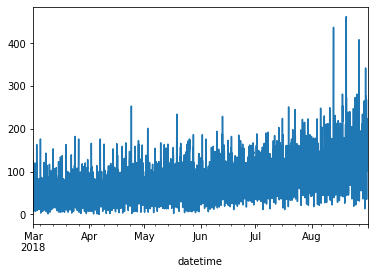

In [8]:
### verificando série original
df['num_orders'].plot()

In [9]:
## decompondo série
decomp = seasonal_decompose(df)

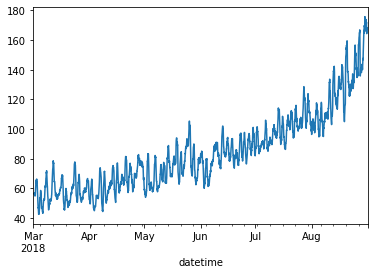

In [10]:
### verificando tendência
decomp.trend.plot()
plt.show()

**Comentário**: A tendência da série é crescer. Isto pode refletir o uso crescente do serviço.

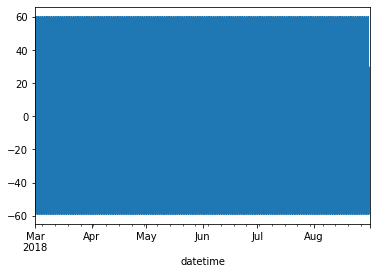

In [11]:
### verificando sazonalidade
decomp.seasonal.plot()
plt.show()

**Comentário**: A série não possui sazonalidade. Isto deve refletir o curto período de tempo analisado.

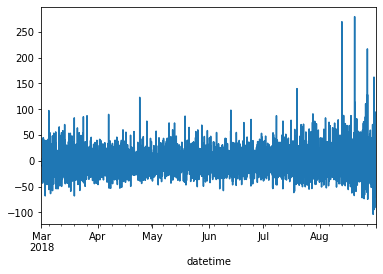

In [12]:
### verificando resíduos
decomp.resid.plot()
plt.show()

**Comentário**: Os resíduos da série são grandes e tendem a aumentar para datas mais recentes. Isto indica uma tendência crresente do número de corridas não seguir uma única distribuição ao longo do tempo.

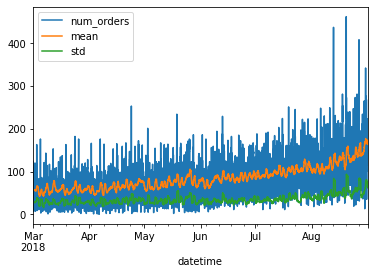

In [13]:
### verificando média e dv baseado no dia (24hrs)
df['mean'] = df['num_orders'].rolling(24).mean()
df['std'] = df['num_orders'].rolling(24).std()
df.plot()
plt.show()

**Comentário**: A série é não-estacionário, ou seja, a média e desvio dos valores mudam ao longo do tempo. Ambas as estatíticas tendem a aumentar com os dias, logo ess informação tem que ser incorporada no modelo de previsão.

### Outras características

In [14]:
###  número de corridas passadas
for lag in range(1, 6):
        df['lag_value{}'.format(lag)] = df['num_orders'].shift(lag)

In [15]:
### médias de corridas dos dias passados
for lag in range(1, 6):
        df['lag_mean{}'.format(lag)] = df['mean'].shift(lag)

In [16]:
### desvio padrão de corridas dos dias passados
for lag in range(1, 6):
        df['lag_std{}'.format(lag)] = df['std'].shift(lag)

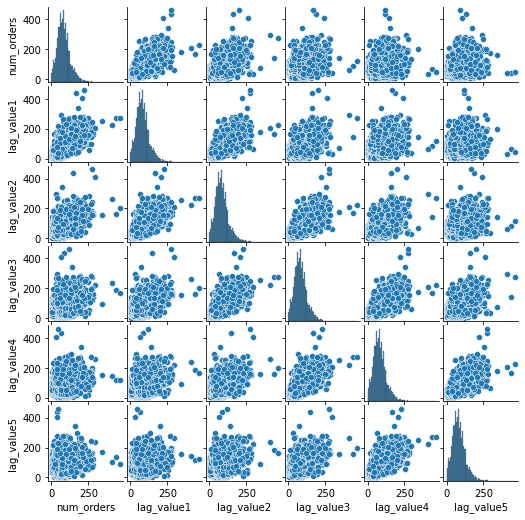

In [17]:
### verificando relação
plot_pair= sns.pairplot(df[["num_orders", "lag_value1", "lag_value2", "lag_value3", "lag_value4", "lag_value5"]], kind='scatter') 
plot_pair.fig.set_size_inches(7, 7)

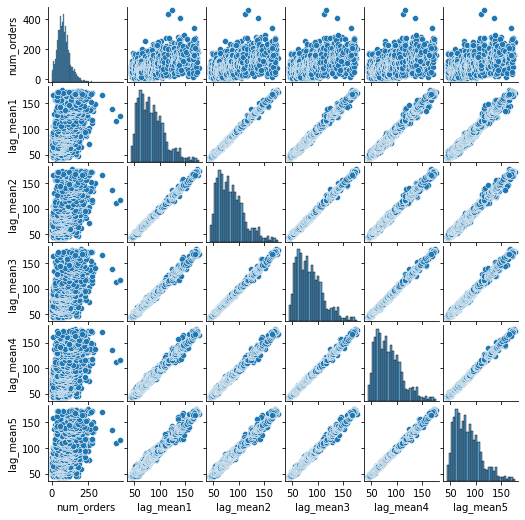

In [18]:
### verificando relação
plot_pair= sns.pairplot(df[["num_orders", "lag_mean1", "lag_mean2", "lag_mean3", "lag_mean4", "lag_mean5"]], kind='scatter') 
plot_pair.fig.set_size_inches(7, 7)

**Comentário**: Aparentemente, a média de corridas dos dias passados tem alguma relação com o número de corridas atual.

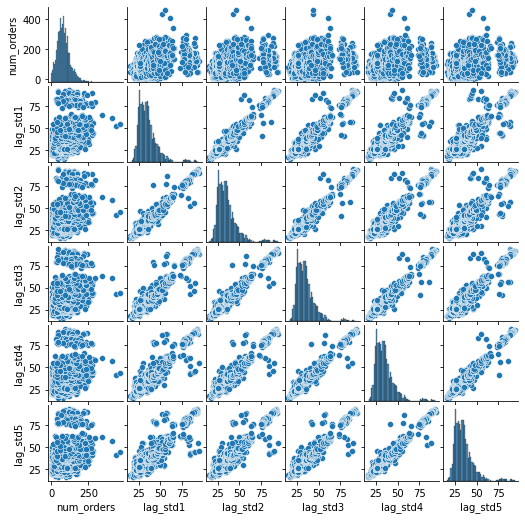

In [19]:
### verificando relação
plot_pair= sns.pairplot(df[["num_orders", "lag_std1", "lag_std2", "lag_std3", "lag_std4", "lag_std5"]], kind='scatter') 
plot_pair.fig.set_size_inches(7, 7)

**Comentário**: Aparentemente, o desvio padrão dos dias passados tem alguma relação com o número de corridas atual.

## Treinamento

### Separando treino, validação e teste

In [20]:
### dividindo dados em treino, validação e teste
train, valid_test = train_test_split(df, shuffle=False, train_size=0.8)
valid, test = train_test_split(valid_test, shuffle=False, train_size=0.5)

In [21]:
### retirando NAs
train = train.dropna()

**Comentário**: Separei os dados em treino (80%), validação (10%) e teste (10%).

### Determinando objetivo e características

In [22]:
### objetivo
train_targ = train['num_orders']
valid_targ = valid['num_orders']
test_targ = test['num_orders']

In [23]:
### características
train_feat = train.drop('num_orders', axis=1)
valid_feat = valid.drop('num_orders', axis=1)
test_feat = test.drop('num_orders', axis=1)

### Definindo funções de treinamento

In [24]:
### definindo função para ajuste de regressão linear
def set_regression_model(features_train, target_train, features_valid, target_valid):
    reg_model = LinearRegression()
    reg_model.fit(features_train, target_train)
    prediction = reg_model.predict(features_valid)
    rmse = np.sqrt( mean_squared_error(target_valid, prediction) )
    print(f'Modelo de regressão - REQM: {round(rmse,2)}')
    return reg_model

In [25]:
### definindo função para ajuste de Random Forest
def set_forest_model(features_train, target_train, features_valid, target_valid, max_est, max_depth):
    best_forest_model = None
    best_est = 0
    best_depth = 0
    best_rmse =  float('inf')
    for est in range(1, max_est):
        for depth in range(1,max_depth):
            forest_model = RandomForestRegressor(n_estimators= est, max_depth= depth, random_state = 42)
            forest_model.fit(features_train, target_train)
            prediction = forest_model.predict(features_valid)
            ## avaliando
            rmse = np.sqrt( mean_squared_error(target_valid, prediction) )
            if (rmse < best_rmse):
                best_forest_model = forest_model
                best_est = est
                best_depth = depth
                best_rmse = rmse
    print(f'Melhor floresta - número de árvores: {best_est}, profundidade: {best_depth}, REQM: {round(best_rmse,2)}')
    return best_forest_model

In [26]:
### definindo função para ajuste de Gradiente Boosting
def set_lgbm_model(features_train, target_train, features_valid, target_valid, n_estimators = 10, max_depth= 10, num_leaves = 30):
    best_lgbm_model = None
    best_est = 0
    best_depth = 0
    best_rmse =  float('inf')
    for est in range(1, n_estimators):
        for depth in range(1, max_depth):
            lgbm_model = LGBMRegressor(num_leaves = num_leaves, max_depth= depth, n_estimators = est, random_state=42)
            lgbm_model.fit(features_train, target_train)
            prediction = lgbm_model.predict(features_valid)
            rmse = np.sqrt( mean_squared_error(target_valid, prediction) )
            if (rmse < best_rmse):
                best_lgbm_model = lgbm_model
                best_est = est
                best_depth = depth
                best_rmse = rmse
    print(f'Melhor LGBM - número de árvores: {best_est}, profundidade: {best_depth}, REQM: {round(best_rmse,2)}')
    return best_lgbm_model

### Treinando modelos

In [27]:
reg_model = set_regression_model(features_train = train_feat, target_train = train_targ, 
                                 features_valid= valid_feat, target_valid= valid_targ)

Modelo de regressão - REQM: 32.5


In [28]:
forest_model = set_forest_model(features_train = train_feat, target_train = train_targ, 
                                features_valid= valid_feat, target_valid= valid_targ,
                                max_est = 20, max_depth = 20)

Melhor floresta - número de árvores: 19, profundidade: 15, REQM: 39.85


In [29]:
lgbm_model = set_lgbm_model(features_train = train_feat, target_train = train_targ, 
                            features_valid= valid_feat, target_valid= valid_targ,
                            n_estimators = 10,  max_depth= 10, num_leaves =31)

Melhor LGBM - número de árvores: 9, profundidade: 9, REQM: 45.54


## Testando

### Juntando treino e validação

In [30]:
### juntando objetivo
train_targ2 = train_targ.append(valid_targ)

In [31]:
### jutnando características
train_feat2 = train_feat.append(valid_feat)

### Testando modelos com melhores parâmetros

In [32]:
reg_model = LinearRegression()
reg_model.fit(train_feat2, train_targ2)
prediction1 = reg_model.predict(test_feat)
rmse1 = np.sqrt( mean_squared_error(test_targ, prediction1) )
print(f'Modelo de regressão - REQM: {round(rmse1,2)}')

Modelo de regressão - REQM: 39.74


In [33]:
forest_model = RandomForestRegressor(n_estimators= 19, max_depth= 15, random_state = 42)
forest_model.fit(train_feat2, train_targ2)
prediction2 = forest_model.predict(test_feat)
rmse2 = np.sqrt( mean_squared_error(test_targ, prediction2) )
print(f'Modelo de floresta - REQM: {round(rmse2,2)}')

Modelo de floresta - REQM: 51.79


In [34]:
lgbm_model = LGBMRegressor(num_leaves = 31, max_depth= 9, n_estimators = 9, random_state=42)
lgbm_model.fit(train_feat2, train_targ2)
prediction3 = lgbm_model.predict(test_feat)
rmse3 = np.sqrt( mean_squared_error(test_targ, prediction3) )
print(f'Modelo LGBM - REQM: {round(rmse3,2)}')

Modelo LGBM - REQM: 63.37


# Conclusão

Eu construi três protótipos de previsão do número de corridas: regreassão linear, floresta aleatória e gradient boosting. Apenas a regressão linear mostrou um poder satisfatório de previsão (REQM < 48). Isto provavelmente se deve a tendência *linear* crescente na média e desvio padrão dos dados. 